In [27]:
# No need to see warnings here
import warnings
warnings.filterwarnings("ignore")
# Matplotlib stuff for plotting
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# h5py to open the hdf5 files
import h5py
# numpy for practically everything
import numpy as np
# setup numpy print options to make it easier on the eyes
np.set_printoptions(precision=2)
# Analysis libraries
import networkx as nx
import pyemma as pe
# Custom functions for this notebook
import analysis_helper as ahelper

# Master WESTPA H5 file

The most important file for WESTPA simulations is the master WESTPA h5 file. 

In [28]:
h = h5py.File('pre_prepped_results/west.h5')
print(", ".join(h.keys()))

bin_topologies, ibstates, iterations, summary, tstates


* bin_topologies contain the mappers used for the simulation, it's possible to pull the mapper object out of the file 
* ibstates contain information regarding the basis (and initial) state information
* iterations contain all the information on a per iteration basis
* summary gives you a nice overall summary of the simulation including the # of walkers per iteration and how much time each 
   iteration took
* tstates contains information regarding target states

Let's check out what's contained in the summary section

In [29]:
h['summary'][10:15]

array([(100, 1., 0.01, 0.38, 0., 0.06, 11.13, 2.14, ''),
       (110, 1., 0.  , 0.28, 0., 0.04, 12.5 , 2.41, ''),
       (120, 1., 0.  , 0.23, 0., 0.03, 13.58, 2.55, ''),
       (130, 1., 0.  , 0.28, 0., 0.04, 14.47, 2.49, ''),
       (120, 1., 0.01, 0.41, 0., 0.06, 12.77, 2.43, '')],
      dtype=[('n_particles', '<i8'), ('norm', '<f8'), ('min_bin_prob', '<f8'), ('max_bin_prob', '<f8'), ('min_seg_prob', '<f8'), ('max_seg_prob', '<f8'), ('cputime', '<f8'), ('walltime', '<f8'), ('binhash', 'S64')])

Let's see what we have in each iteration

In [30]:
print(", ".join(h['iterations/iter_%08d'%100].keys()))

bin_target_counts, ibstates, pcoord, seg_index, wtgraph


* bin_target_counts give you how many walkers per bin we have
* ibstates is basically the same as before, for this iteration (important for recycling)
* pcoord contains your progress coordinates for the entire iteration
* seg_index includes information regarding the specific walker, like the history parent id or recycling status
* wtgraph includes all parents, not just the history parent
* additional data that can be passed to WESTPA will be stored here under 'auxdata'

seg_index includes important information regarding the history parents of each walker (parent_id) and if a walker 
is recycled or not (endpoint_type). 

In [31]:
print(h['iterations/iter_%08d'%10]['seg_index'][...].shape)
h['iterations/iter_%08d'%10]['seg_index'][10:15]

(90,)


array([(0., 25, 1, 27, 0.17, 0.19, 1, 2),
       (0., 66, 2, 28, 0.12, 0.13, 1, 2),
       (0., 25, 1, 30, 0.17, 0.18, 1, 2),
       (0., 25, 1, 31, 0.17, 0.18, 2, 2),
       (0., 25, 1, 32, 0.15, 0.16, 2, 2)],
      dtype=[('weight', '<f8'), ('parent_id', '<i8'), ('wtg_n_parents', '<u8'), ('wtg_offset', '<u8'), ('cputime', '<f8'), ('walltime', '<f8'), ('endpoint_type', 'u1'), ('status', 'u1')])

wtgraph includes all parent information (not just the history parent)

In [32]:
print(h['iterations/iter_%08d'%10]['wtgraph'][...].shape)
h['iterations/iter_%08d'%10]['wtgraph'][10:20]

(123,)


array([ 6, 16, 11, 50, 67, 55, 56, 15, 59, 13])

# w_assign and the assign.h5 file

An important WESTPA tool is called w_assign which can be used to assign indices to each walker. It's highly flexible since
you can pass a python function to determine the index of each walker. By default w_assign will use the bin mapper found
in the master WESTPA h5 file. Also, unless a python function is given, w_assign will generally expect a rectilinear binning
scheme unless it's using the one in the master WESTPA h5 file.

In [33]:
a = h5py.File('pre_prepped_results/assign.h5')
print(", ".join(a.keys()))

assignments, bin_labels, labeled_populations, npts, nsegs, state_labels, state_map, statelabels, trajlabels


let's explore some of these options.

w_assign expects a set of states and bins to assign everything to. states are generally expected to be metastable states
and bins can be any binning scheme you want. You can map multiple bins to a single state

In this example file I used 4 states, each of which falls into a single bin. You can see the names I gave under 'state_labels'

In [34]:
print(a['state_labels'][...])

['high_low' 'low_high' 'low_low' 'high_high']


I have 100 bins (100 voronoi centers in this case), you can see how each bin maps to each state under 'state_map'

In [35]:
print(a['state_map'][...], a['state_map'][...].shape)

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=uint16), (101,))


We can also see what each bin is supposed to be under 'bin_labels', here is the voronoi center for bin 10

In [36]:
print(a['bin_labels'][10])

center=array([21., 21.,  0.,  1.,  0.,  0.,  1.,  0.], dtype=float32)


The main thing we want is an assignment for each walker so that we can calculate some properties for each bin/voronoi center
e.g. a transition matrix from center to center or the average value of something in a particular center. This can be found
under 'assignments', shape is (# of iterations, maximum # of walkers, # of dimensions)

In [37]:
print(a['assignments'][...].shape)
print(a['assignments'][10][:3])

(100, 780, 2)
[[ 2  0]
 [62 91]
 [85 62]]


We can find the label that's assigned to each point using 'statelabels'

In [38]:
print(a['statelabels'][...].shape)
print(a['statelabels'][10][0:3])

(100, 780, 2)
[[4 4]
 [4 4]
 [4 4]]


We can also find a 'trajlabel', this is calculated such that it retains the last state it visited. e.g. say a walker went
into state 1, left but is not considered in another state yet, it will retain the index 1. This can be seen here with 
0th walker in iteration 10, [10][0] is currently not in a state (4), but has last visited state (1).

In [39]:
print(a['trajlabels'][10][0:3])

[[4 4]
 [4 4]
 [4 4]]


# w_pdist and pdist.h5 file

In [40]:
p = h5py.File('pre_prepped_results/pdist.h5')
print(", ".join(p.keys()))

binbounds_0, binbounds_1, histograms, midpoints_0, midpoints_1, n_iter


* binbounds_0, ..., binbounds_n are the bin boundaries used in histogramming
* histograms contain the histogram values (in probability
* midpoints_0, ..., midpoints_n are the middle of each bin for easier plotting
* n_iter is the # of iterations used in the histogramming

We can use this to plot histograms of each dimension given to w_pdist. You can give more than 2 dimensions to w_pdist but I suggest sticking to 2D histograms especially for larger WESTPA simulations.

In [41]:
hist = p['histograms'][...]
# Shape is (# of iterations, # of bins in dimension 0, ..., # of bins in dimension n)
print(hist.shape)
print(hist[10][:5,:5])

(100, 30, 30)
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.06 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.   0.04]]


(30, 30)
((30,), (30,))


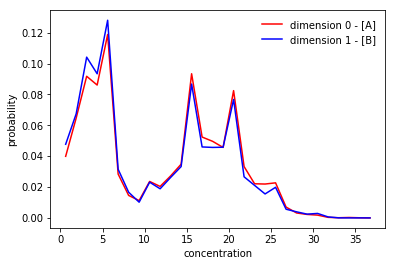

In [42]:
# First average over iterations
H = np.average(hist, axis=0)
print(H.shape)
# Next calculate the probability distribution in each dimension
H_x = np.sum(H, axis=0)
H_x = H_x/H_x.sum()
H_y = np.sum(H, axis=1)
H_y = H_y/H_y.sum()
print(H_x.shape, H_y.shape)
# Now plot both 
plt.plot(p['midpoints_0'][...], H_x, c='r', label='dimension 0 - [A]')
plt.plot(p['midpoints_1'][...], H_y, c='b', label='dimension 1 - [B]')
plt.ylabel("probability")
plt.xlabel("concentration")
plt.legend(frameon=False)
plt.show()
# We expect identical in each dimension since the model is symmetrical in A and B

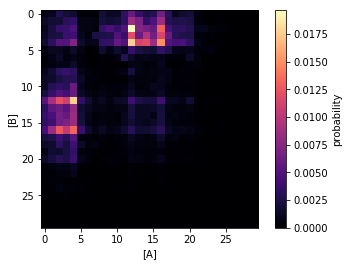

In [43]:
# Now plot color map 
im = plt.imshow(H, cmap=plt.get_cmap("magma"))
_ = plt.colorbar(im, label="probability")
plt.xlabel("[A]")
plt.ylabel("[B]")
plt.show()

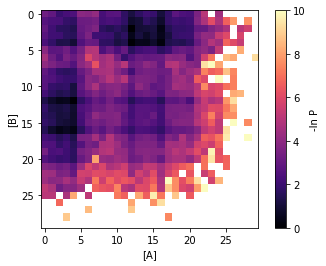

In [62]:
# SHOULD I INCLUDE THIS?
# Generally a -ln P makes things easier to see and converts the probability to a estimate of the free energy
lnp = -np.log(H)
lnp = lnp - lnp.min()
im = plt.imshow(lnp, cmap=plt.get_cmap("magma"), vmax=10)
_ = plt.colorbar(im, label="-ln P")
plt.xlabel("[A]")
plt.ylabel("[B]")
plt.show()

# Sample analysis

We can now use some of this information to analyze our data. 

Let's calculate a transition matrix using the assignments we have. 
TODO: Port the code here, make sure they can fall back to pre-calculated

[[1.99e-02 1.17e-03 1.25e-02 ... 0.00e+00 2.24e-05 0.00e+00]
 [9.95e-04 1.43e-04 6.04e-04 ... 0.00e+00 0.00e+00 5.87e-05]
 [1.18e-02 8.44e-04 5.14e-03 ... 0.00e+00 5.23e-05 8.08e-06]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [2.26e-04 0.00e+00 1.31e-04 ... 0.00e+00 2.44e-04 0.00e+00]
 [3.33e-06 3.88e-05 4.18e-07 ... 0.00e+00 0.00e+00 9.10e-07]]


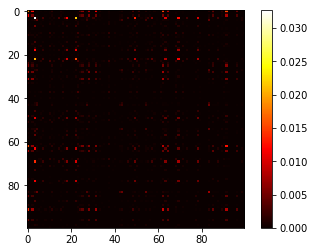

In [44]:
tm = np.load('pre_prepped_results/tm.npy')
tm = tm[:,:][:,:]
print(tm)
im = plt.imshow(tm, cmap=plt.get_cmap('hot'))
_ =plt.colorbar(im)
# TODO: Write a plotting function to plot the matrix and show how symmetrizing changes things

We can make a markov chain over the voronoi bins, the transition matrix has to be symmetrized to fulfill equilibrium 
conditions for future analysis

[[1.51e-01 8.22e-03 9.24e-02 ... 0.00e+00 9.45e-04 1.27e-05]
 [8.63e-02 1.14e-02 5.77e-02 ... 0.00e+00 0.00e+00 3.89e-03]
 [1.81e-01 1.08e-02 7.66e-02 ... 0.00e+00 1.37e-03 6.33e-05]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [1.45e-02 0.00e+00 1.07e-02 ... 0.00e+00 2.84e-02 0.00e+00]
 [7.27e-04 2.13e-02 1.85e-03 ... 0.00e+00 0.00e+00 3.97e-04]]


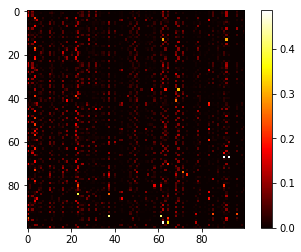

In [45]:
stm = ahelper.symmetrize(tm)
# Row normalize to turn this into a proper row stochastic transition matrix
ntm = ahelper.row_normalize(stm)
print(ntm)
im = plt.imshow(ntm, cmap=plt.get_cmap('hot'))
_ =plt.colorbar(im)

Use pyEmma to do PCCA+ coarse graining, finding metastable states and a transition matrix between them

[[ 6.36e-01  1.09e-02  1.72e-01  1.81e-01]
 [ 8.80e-04  8.43e-01  8.02e-02  7.57e-02]
 [ 6.61e-02  2.65e-02  9.12e-01 -4.64e-03]
 [ 5.84e-02  2.57e-02  3.54e-03  9.12e-01]]
[0.13 0.13 0.38 0.36]


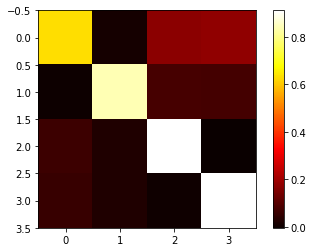

In [46]:
MSM = pe.msm.MSM(ntm, reversible=True)
pcca = MSM.pcca(4) # We know we have 4 states in this case, skipping timescales calculation here
p = pcca.coarse_grained_stationary_probability
ctm = pcca.coarse_grained_transition_matrix
# This is our coarse grained, 4x4 transition matrix
print(ctm)
# p is the stationary probability distribution as implied by our transition matrix
print(p)
im = plt.imshow(ctm, cmap=plt.get_cmap('hot'))
_ = plt.colorbar(im)
# TODO: Write a tool to plot network graphs, turn both the full matrix and the coarse matrix to graphs and plot both

let's find out what our coarse grained states look like on average! 

In [47]:
mstable_assign = pcca.metastable_assignment
# using the bin labels (voronoi centers) and finding the average value for the centers
bin_labels = ahelper.get_bin_labels(a)

print("metastable state 0")
print(bin_labels[mstable_assign.T==0].mean(axis=0))
print("metastable state 1")
print(bin_labels[mstable_assign.T==1].mean(axis=0))
print("metastable state 2")
print(bin_labels[mstable_assign.T==2].mean(axis=0))
print("metastable state 3")
print(bin_labels[mstable_assign.T==3].mean(axis=0))

metastable state 0
[4.22 2.78 0.56 0.   0.44 0.56 0.   0.44]
metastable state 1
[21.64 21.81  0.    0.98  0.02  0.    1.    0.  ]
metastable state 2
[ 4.86 21.18  0.21  0.14  0.64  0.    0.96  0.04]
metastable state 3
[20.71  4.52  0.05  0.95  0.    0.19  0.05  0.76]


We want to...

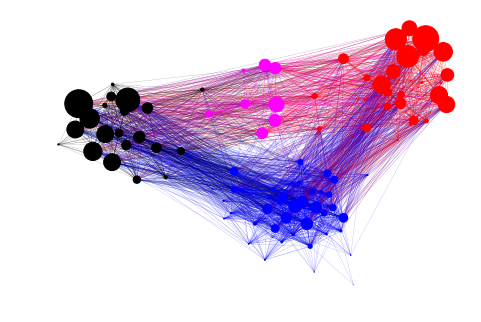

In [48]:
# Start with full network
state_colors = {0: "#FF00FF", 1: "#0000FF", 2: "#FF0000", 3: "#000000"}
FG = nx.DiGraph()
tm = pcca.transition_matrix
edge_sizes = pcca.transition_matrix
node_sizes = pcca.stationary_probability
# building network
for i in range(tm.shape[0]):
    if node_sizes[i] > 0:
        FG.add_node(i, weight=float(node_sizes[i]))
for i in range(tm.shape[0]):
    for j in range(tm.shape[1]):
        if i != j:
            if edge_sizes[i][j] > 1e-3:
                FG.add_edge(i, j, weight=float(edge_sizes[i][j]))
nx.draw(FG, pos=nx.spring_layout(FG, k=0.1), 
            node_color=[state_colors[mstable_assign[i]] for i in FG.nodes()], node_size=[i*10000 for i in node_sizes],
            edge_color=[state_colors[mstable_assign[i[0]]] for i in FG.edges()], width=0.1, arrows=False)
plt.show()
plt.close()

Coarse grained network...

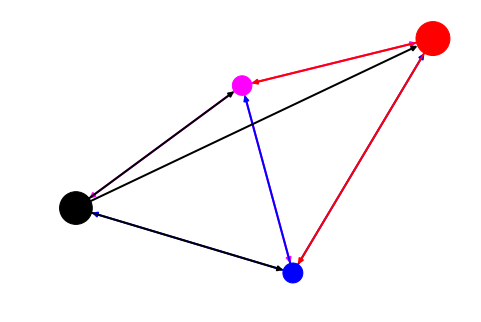

In [49]:
# Do the coarse grained network next
CG = nx.DiGraph()
tm = pcca.coarse_grained_transition_matrix
edge_sizes = pcca.coarse_grained_transition_matrix
node_sizes = pcca.coarse_grained_stationary_probability
# building network
for i in range(tm.shape[0]):
    if node_sizes[i] > 0:
        CG.add_node(i, weight=float(node_sizes[i]), color=state_colors[mstable_assign[i]])
for i in range(tm.shape[0]):
    for j in range(tm.shape[1]):
        if i != j:
            if edge_sizes[i][j] > 0:
                CG.add_edge(i, j, weight=float(edge_sizes[i][j]))
nx.draw(CG, pos=nx.spring_layout(CG), 
            node_color=[state_colors[i] for i in CG.nodes()], node_size=[i*3000 for i in node_sizes],\
            edge_color=[state_colors[i[0]] for i in CG.edges()], width=2, )
plt.show()